In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
from numpy.linalg import norm
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import random
import time
import os
import copy
import cv2
from PIL import Image
from IPython.display import display
from time import time

cudnn.benchmark = True
plt.ion()   # interactive mode

In [12]:
# Utils functions for dataset creating
def scale_image(photo, scale=None):
    if scale is None:
        scale = np.random.uniform(0.7, 1.5)
    scale = np.round(scale, 4)
    width = int(photo.shape[1] * scale)
    height = int(photo.shape[0] * scale)
    dim = (width, height)
    result = cv2.resize(photo, dim, interpolation = cv2.INTER_AREA)
    return result, scale

def rotate_image(image, angle=None):
    height, width = image.shape[:2]
    center = (width/2, height/2)
    if angle is None:
        angle = np.random.randint(5, 180)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1)
    result = cv2.warpAffine(image, rot_mat, dsize=(width, height), flags=cv2.INTER_LINEAR)
    return result, angle

def crop_image(image):
    cx, cy = int(image.shape[0]/2), int(image.shape[1]/2)
    ltrb = cx - 80, cy - 160, cx + 80, cy + 160
    ltrb = [max(0,i) for i in ltrb]
    crop = image[ltrb[0]:ltrb[2], ltrb[1]:ltrb[3]]
    return crop

def get_transform(photo):
    r_img, angle = rotate_image(photo)
    scl_img, scale = scale_image(r_img)
    img = crop_image(scl_img)
    return img, scale, angle

**Dataset**

In [13]:
# img_shape = 320x160
# GrayScale
class SingleImageDataset(Dataset):
    def __init__(self, path_to_file, crop_shape = (320,160), step_px = 20, transform = None):
        self.crop_shape = crop_shape
        self.step_px = step_px
        img = cv2.imread(path_to_file)
        self.img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.x_step_number = (img.shape[0] - crop_shape[0])//step_px
        self.y_step_number = (img.shape[1]- crop_shape[1])//step_px
        self.transform = transform
        self.crops = []
        self.__init_classes()

    
    def step2ltrb(self, x_step, y_step):
        left = x_step * self.step_px
        top = y_step * self.step_px
        right, bottom = left + self.crop_shape[0], top + self.crop_shape[1]
        return left, top, right, bottom
    
    def __init_classes(self):
        for x_step in range(self.x_step_number):# left to right
            for y_step in range(self.y_step_number): # up to down
                left, top, right, bottom = self.step2ltrb(x_step, y_step)
                crop = self.img[top:bottom, left:right]
                self.crops.append(crop)
    
    def __len__(self):
        return len(self.crops)
    
    def __getitem__(self, idx):
        crop = self.crops[idx]
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        if self.transform:
            crop = self.transform(crop)
        return crop
    
    def get_random_crop(self):
        x_step = random.randint(0, self.x_step_number)
        y_step = random.randint(0, self.y_step_number)
        #print(f'x - {x_step}, y - {y_step}')
        left, top, right, bottom = self.step2ltrb(x_step, y_step)
        shift = random.randint(0, int((self.crop_shape[1])/2))
        left, top, right, bottom = left+shift, top+shift, right+shift, bottom+shift
        source = self.img[top:bottom, left:right]
        source = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
        test_left, test_top, test_right, test_bottom = left, top, right, bottom
        test_left, test_right = test_left-100, test_right+100
        test_top, test_bottom = test_top-100, test_bottom+100
        shift_ltrb = [max(0,i) for i in [test_left, test_top, test_right, test_bottom]]
        raw = self.img[shift_ltrb[1]:shift_ltrb[3], shift_ltrb[0]:shift_ltrb[2]]
        raw = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        test_crop, scale, angle = get_transform(raw)
        
        source = self.transform(source)
        test_crop = self.transform(test_crop)
        return source, raw, test_crop, scale, angle
        


transform_pipe = transforms.Compose([
    transforms.ToTensor(),
    ])


path_to_img = 'shlyuz.jpg'
crop_shape = (320, 160)
step_px = 40

tic = time()
train_dataset = SingleImageDataset(path_to_img, 
                         crop_shape = crop_shape,
                         step_px = step_px, 
                         transform=transform_pipe)
print(f'time elapsed for dataset initialization {time()-tic:.4f}')

time elapsed for dataset initialization 1.8562


In [14]:
len_dataset = len(train_dataset)
len_dataset

98592

In [15]:
train_dataset.img.shape

(12800, 12800, 3)

In [16]:
train_dataset[0]

tensor([[[0.2980, 0.3098, 0.3216,  ..., 0.2471, 0.2431, 0.2392],
         [0.2706, 0.2824, 0.3020,  ..., 0.2431, 0.2431, 0.2392],
         [0.2431, 0.2549, 0.2824,  ..., 0.2353, 0.2392, 0.2431],
         ...,
         [0.3804, 0.3765, 0.3686,  ..., 0.3451, 0.3529, 0.3569],
         [0.3804, 0.3765, 0.3686,  ..., 0.3529, 0.3569, 0.3608],
         [0.3765, 0.3725, 0.3647,  ..., 0.3529, 0.3608, 0.3647]]])

## Dataset check in

In [17]:
t2pil = transforms.ToPILImage()

In [18]:
canvas = Image.new(mode="RGB", 
                       size=crop_shape)
for n in range(3):
    crop = train_dataset[n]
    print(f'n = {n},')
    if n >= 0:
        canvas.paste(t2pil(crop), (0, 0))
        if n < 1:
            cnvs_w, cnvs_h = canvas.size
        canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)
        display(canvas)
        canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)

In [9]:
# sorce, raw, test_crop, scale, angle = train_dataset.get_random_crop()

# if n >= 0:
#     canvas.paste(t2pil(sorce), (0, 0))
#     if n < 1:
#         cnvs_w, cnvs_h = canvas.size
#         #cnvs_w, cnvs_h = cnvs_w, cnvs_h
#     canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)
#     display(canvas)
#     canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)

In [10]:
# if n >= 0:
#     canvas.paste(t2pil(test_crop), (0, 0))
#     if n < 1:
#         cnvs_w, cnvs_h = canvas.size
#         #cnvs_w, cnvs_h = cnvs_w, cnvs_h
#     canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)
#     display(canvas)
#     canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)

In [19]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, num_workers=1
)

**Model**

In [37]:
#https://arxiv.org/pdf/2102.05692.pdf

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(Conv, self).__init__()
        self.conv2d = nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=3,
                                stride=stride,
                                padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.bn(x)
        x = self.leaky(x)
        return x

class DownLinear(nn.Module):
    def __init__(self, in_channels=51200, out_channels=1000):
        super(DownLinear, self).__init__()
        self.flatten = nn.Flatten(0)
        self.fc1 = nn.Linear(51200, out_channels)
        self.fc2 = nn.Linear(51200, out_channels)
    
    def forward(self, x):
        x = self.flatten(x)
        return self.fc1(x), self.fc2(x)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.down = nn.Sequential(Conv(1, 64),
                                  Conv(64, 128),
                                  Conv(128, 256),
                                  Conv(256, 512),
                                  Conv(512, 1024),
                                  DownLinear(51200, 1000)
                                  )
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def forward(self, x):
        mu, logvar = self.down(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
#_____________________________________________________


class UpLinear(nn.Module):
    def __init__(self):
        super(UpLinear, self).__init__()
        self.fc = nn.Linear(1000, 51200)
        self.relu = nn.ReLU()
    
    def forward(self, z):
        z = self.relu(self.fc(z))
        z = z.view(-1, 1024, 5, 10)
        return z
        

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode, kernel_size=2, stride=2):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels, 
                                                in_channels, 
                                                kernel_size=kernel_size,
                                                stride=stride)        
        else:
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.pd = nn.ReplicationPad2d(1)
        self.conv = Conv(in_channels, out_channels, stride=1)

    def forward(self, down_input):
        x = self.up_sample(down_input)
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.up_sample_mode='conv_transpose'
        self.up = nn.Sequential(UpLinear(),
                                UpBlock(1024, 512, self.up_sample_mode),
                                UpBlock(512, 256, self.up_sample_mode),
                                UpBlock(256, 128, self.up_sample_mode),
                                UpBlock(128, 64, self.up_sample_mode),
                                UpBlock(64, 1, self.up_sample_mode),
                                nn.Sigmoid()
                                )
    
    def forward(self, z):
        return self.up(z)
#_____________________________________________________


class VarAutoEncoder(nn.Module):
    def __init__(self, out_classes=1):
        super(VarAutoEncoder, self).__init__()
        # Downsampling Path
        self.encoder = Encoder()
        # Upsampling Path
        self.decoder = Decoder()

    def forward(self, x):
        encoded, mu, logvar = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, mu, logvar
    
    def encode(self, img):
        return self.encoder(img)
    
    def decode(self, vec):
        return self.decoder(vec)
       

__TRAIN__

In [33]:
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

In [ ]:
TRAIN = True
EPOCHS = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_loss = 1.0
train_loss = []

if TRAIN:
    model = VarAutoEncoder()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr= 0.001)
    best_model_wts = copy.deepcopy(model.state_dict())

    model.train()
    for i in range(EPOCHS):
        print(f"epoch: {i + 1}")
        samples = 0
        loss_sum = 0
        correct_sum = 0
        for img in train_loader:
            img = img.cuda()
            out, mu, logvar = model(img)
            loss = loss_function(out, img, mu, logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.data.item()
            samples += img.shape[0]

        # Print epoch statistics
        epoch_loss = float(loss_sum) / float(samples)
        print(f"loss: {epoch_loss}")
        train_loss.append(epoch_loss)

        # Deep copy the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, f"VAE_epoch_{i + 1}.pth")
            pic = out.cpu().data
            save_image(pic, 'image_{}.png'.format(i))

    last_model_wts = copy.deepcopy(model.state_dict())
    torch.save(last_model_wts, f"VAE_last.pth")


epoch: 1


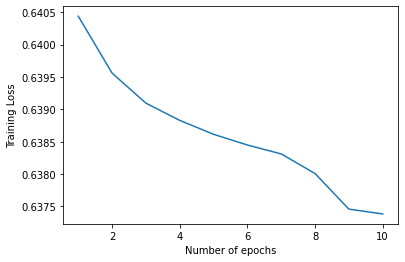

In [18]:
# Plotting the training loss
num_epochs = EPOCHS
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

## Model prediction check in

In [17]:
if not TRAIN:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    PATH = './VAE_epoch_10.pth'
    model = AutoEncoder()
    model.load_state_dict(torch.load(PATH))
    model.to(device)


In [18]:
# Prepare vectors and coords for All crops (maps)
i = 0
vectors = []
coords = []
for n in range(len(train_dataset)):
    x = n//train_dataset.y_step_number
    y = n%train_dataset.y_step_number
    crop = train_dataset[n]
    crop = crop[None, :, :, :]
    crop = crop.cuda()
    vector = model.encode(crop)
    vector = vector.cpu().detach().numpy()
    coords.append([x,y])
    vectors.append(vector)

In [19]:
coords = np.array(coords)
np_vectors = np.array(vectors)

In [20]:
print(len(np_vectors))
print(len(coords))

98592
98592


## let's do a simple test

coord x - 46, coord y - 31


/tmp/ipykernel_653/1909618201.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)


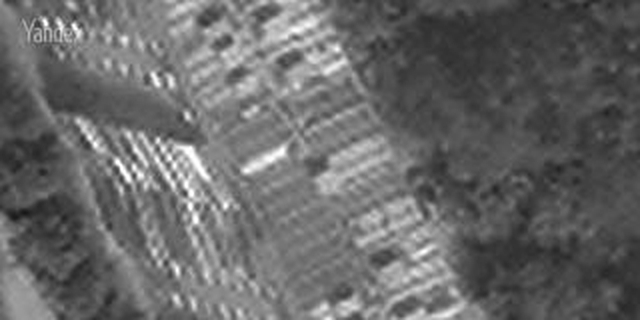

/tmp/ipykernel_653/1909618201.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)


In [31]:
# take a photo. well, like (/\ _ /\)

index = 14567 #random.randint(0, 98592)

photo = train_dataset[index]
coord_x = index//train_dataset.y_step_number
coord_y = index%train_dataset.y_step_number
print(f"coord x - {coord_x}, coord y - {coord_y}")
canvas.paste(t2pil(photo), (0, 0))
canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)
display(canvas)
canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)

In [32]:
# take vector from 'photo' (model.encode())
photo = photo[None, :, :, :]
photo = photo.cuda()
vector = model.encode(photo)
vector = vector.cpu().detach().numpy()

In [33]:
#define index by cos simularity
# np_vectors.shape = (1000, 98592)
cos_max = 0.1
found_indx = 0

for n, vec in enumerate(np_vectors):
    res = np.dot(vec, vector)/(norm(vec)*norm(vector))
    if res > cos_max:
        cos_max = res
        found_indx = n # well done

In [202]:
print(f'real indx- {index}, found index- {found_indx}')

real indx- 14567, found index- 14567


In [35]:
# prepare reference images # 324 imgs arround
# define neighbours indexes
indexes = []

for step in range(-4, 5):
    x_ind = found_indx - step*train_dataset.y_step_number
    y_ind = [i for i in range((x_ind - 4), (x_ind + 5))] #index%train_dataset.y_step_number
    indexes.append(y_ind)

square = 9*9
indexes = np.array(indexes)
indexes = np.reshape(indexes, (square, 1))


In [36]:
reference_img = np_vectors[indexes] # Yge
reference_coord = coords[indexes] # Xge
reference_img = np.reshape(reference_img, (square, 1000))
reference_coord = np.reshape(reference_coord, (square, 2))

In [41]:
# Calculate the coordinates
# weights:
w = reference_img @ vector # Yge * y
std_w = np.std(w)
max_w = w.max()
# discard outliers
limit = max_w - std_w
w[w<limit] = 0

# And summ (Normalize -like)
summ = w.sum()
Wth = w/summ

In [42]:
axis = '''
 
/ \  x
 |
  __\ y
    /
'''
print(axis)
for n, line in enumerate(np.reshape(Wth, (9, 9))):
    print(*line)
    if n==3 or n == 4:
        print('')


 
/ \  x
 |
  __\ y
    /

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


**Get [x, y]**

In [43]:
# coordinates 
x_y = reference_coord.T @ Wth # Xge * Wth

In [44]:
print('index', index)
print(f'real_x - {coord_x}, real_y - {coord_y}')

print('\nfound_index', found_indx)
print(f'found_x {x_y[0]}, found_y {x_y[1]}')

index 14567
real_x - 46, real_y - 31

found_index 14567
found_x 46.0, found_y 31.0


In [ ]:
def visualize(images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image[0])
    plt.show()

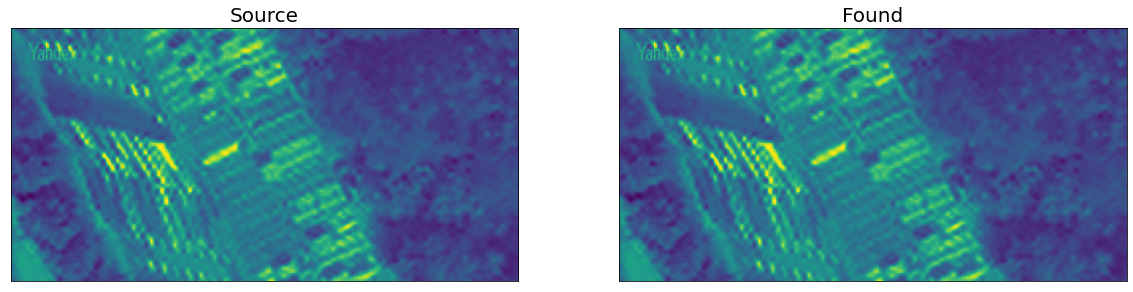

In [46]:
images = {'source': train_dataset[index], 'found': train_dataset[found_indx]}

visualize(images)

Yoohu - simple test completed

**decode-power testing**

In [47]:
vector = model.encode(photo)
vector = vector.cuda()

/tmp/ipykernel_653/1082811786.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)


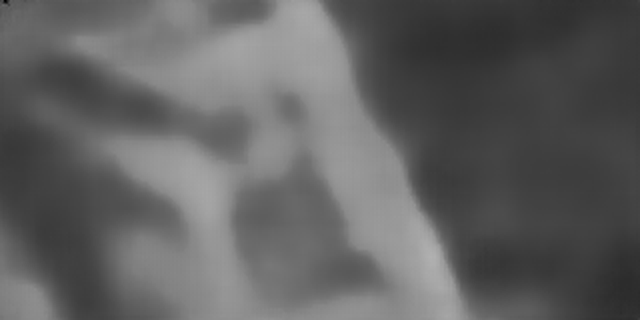

/tmp/ipykernel_653/1082811786.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)


In [48]:
images = model.decode(vector) # magic
canvas = Image.new(mode="RGB", 
                       size=crop_shape)
canvas.paste(t2pil(images[0]), (0, 0))
canvas = canvas.resize((2*cnvs_w, 2*cnvs_h), Image.ANTIALIAS)
display(canvas)
canvas = canvas.resize((cnvs_w, cnvs_h), Image.ANTIALIAS)

__export .onnx__

In [98]:
# export onnx (rknn-toolkit2 only support to opset_version=12)
model.to("cpu")
encoder = model.encoder
#x = torch.randn((1, 1, 160, 320))
x = torch.randn((1, 1, crop_shape[1], crop_shape[0]))
encoder.eval()
torch.onnx.export(encoder, x, f'./var_encoder_{crop_shape[0]}.onnx', opset_version=12, input_names=['input'], output_names=['output'])

In [ ]:
len(encoder(x))
#-> 1000

__model.pt SAVE__

In [99]:
input_tensor = torch.randn((1, 1,  crop_shape[1], crop_shape[0]))
model.to("cpu")
model.eval()
encoder = model.encoder
encoder.to("cpu")
encoder.eval()
traced_script_module = torch.jit.trace(encoder, input_tensor)
traced_script_module.save(f"var_encoder_{crop_shape[0]}.pt")